In [1]:
#load in libraries
import numpy as np
import pandas as pd
import pickle
import glob
import random
import numpy as np
import os.path as op
import time
import nltk
nltk.download('punkt')
import re

[nltk_data] Downloading package punkt to /Users/evandowns/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import pickle
import glob
import os.path as op

In [46]:
#include data preprocessing here
#load in dataset
url = 'https://raw.githubusercontent.com/cs7641-team4/cs7641project/main/data/EMNLP2020.csv'
data = pd.read_csv(url)
data.head()

,title,abstract,authors,pdf_url,url,label1,label2
0,Blank Language Models,"We propose Blank Language Model (BLM), a model...","['Tianxiao Shen', 'Victor Quach', 'Regina Barz...",https://www.aclweb.org/anthology/2020.emnlp-ma...,https://www.aclweb.org/anthology/2020.emnlp-ma...,2.0,4.0
1,Acrostic Poem Generation,We propose a new task in the area of computati...,"['Rajat Agarwal', 'Katharina Kann']",https://www.aclweb.org/anthology/2020.emnlp-ma...,https://www.aclweb.org/anthology/2020.emnlp-ma...,2.0,NaN
2,Unsupervised Adaptation of Question Answering ...,BERT-era question answering systems have recen...,"['Steven Rennie', 'Etienne Marcheret', 'Neil M...",https://www.aclweb.org/anthology/2020.emnlp-ma...,https://www.aclweb.org/anthology/2020.emnlp-ma...,5.0,NaN
3,An Imitation Game for Learning Semantic Parser...,"Despite the widely successful applications, bo...","['Ziyu Yao', 'Yiqi Tang', 'Wen-tau Yih', 'Huan...",https://www.aclweb.org/anthology/2020.emnlp-ma...,https://www.aclweb.org/anthology/2020.emnlp-ma...,8.0,1.0
4,Conversational Semantic Parsing,The structured representation for semantic par...,"['Armen Aghajanyan', 'Jean Maillard', 'Akshat ...",https://www.aclweb.org/anthology/2020.emnlp-ma...,https://www.aclweb.org/anthology/2020.emnlp-ma...,8.0,1.0


In [47]:
#clean abstracts
def clean(txt):
    sents = nltk.sent_tokenize(txt)
    txt_clean = [nltk.tokenize.word_tokenize(re.sub(r'[^a-z ]', ' ', sent.lower())) for sent in sents]
    
    return txt_clean

#apply clean function
abstracts = data["abstract"].apply(clean)
abstractsArr = abstracts.values
#unnest abstracts to get list of sentences
sents = [item for l in abstractsArr for item in l]
#clean sents
clean_sents = [sent for sent in sents if len(sent) > 0]
#unnest sentences to get words
words = [word for sent in clean_sents for word in sent]
#convert only unique words to a dictionary, and also create a list
#get unique words
uniqueWords = pd.DataFrame(words).drop_duplicates().reset_index()
#get list of unique words
wordList = uniqueWords[0].to_list()
wordDict = uniqueWords[0].to_dict()
#inverse the dictionary so given a word will give index
inv_Dict = {v:k for k, v in wordDict.items()}

In [48]:
wordList[0]

'we'

In [49]:
inv_Dict['we']

0

In [5]:
class create_dataset():
    def __init__(self, tokens, data_phrases, mapping):
        self.tokens = tokens
        self.data_phrases = data_phrases
        self.mapping = mapping
    
    def sampleTokenIdx(self):
        return random.randint(0, len(self.mapping) - 1)
    
    def getRandomContext(self, C=5):
        allsent = self.data_phrases 
        sentID = random.randint(0, len(allsent) - 1)
        sent = allsent[sentID]
        wordID = random.randint(0, len(sent) - 1)

        context = sent[max(0, wordID - C):wordID]
        if wordID+1 < len(sent):
            context += sent[wordID+1:min(len(sent), wordID + C + 1)]

        centerword = sent[wordID]
        context = [w for w in context if w != centerword]

        if len(context) > 0:
            return centerword, context
        else:
            return self.getRandomContext(C)

In [51]:
def normalizeRows(x):
    """ Row normalization function

    Implement a function that normalizes each row of a matrix to have
    unit length.
    """
    N = x.shape[0]
    x /= np.sqrt(np.sum(x**2, axis=1)).reshape((N,1)) + 1e-30
    return x

In [52]:
def softmax(x):
    """Compute the softmax function for each row of the input x.
    It is crucial that this function is optimized for speed because
    it will be used frequently in later code. 

    Arguments:
    x -- A D dimensional vector or N x D dimensional numpy matrix.
    Return:
    x -- You are allowed to modify x in-place
    """
    orig_shape = x.shape

    if len(x.shape) > 1:
        # Matrix
        tmp = np.max(x, axis=1)
        x -= tmp.reshape((x.shape[0], 1))
        x = np.exp(x)
        tmp = np.sum(x, axis=1)
        x /= tmp.reshape((x.shape[0], 1))
    else:
        # Vector
        tmp = np.max(x)
        x -= tmp
        x = np.exp(x)
        tmp = np.sum(x)
        x /= tmp

    assert x.shape == orig_shape
    return x

In [53]:
def sigmoid(x):
    """
    Compute the sigmoid function for the input here.
    Arguments:
    x -- A scalar or numpy array.
    Return:
    s -- sigmoid(x)
    """

    ### YOUR CODE HERE
    s = (1/(1+np.exp(-x)))
    ### END YOUR CODE

    return s

In [54]:
def naiveSoftmaxLossAndGradient(
    centerWordVec,
    outsideWordIdx,
    outsideVectors,
    dataset
):
    """ Naive Softmax loss & gradient function for word2vec models

    Implement the naive softmax loss and gradients between a center word's 
    embedding and an outside word's embedding. This will be the building block
    for our word2vec models.

    Arguments:
    centerWordVec -- numpy ndarray, center word's embedding
                    (v_c in the pdf handout)
    outsideWordIdx -- integer, the index of the outside word
                    (o of u_o in the pdf handout)
    outsideVectors -- outside vectors (rows of matrix) for all words in vocab
                      (U in the pdf handout)
    dataset -- needed for negative sampling, unused here.

    Return:
    loss -- naive softmax loss
    gradCenterVec -- the gradient with respect to the center word vector
                     (dJ / dv_c in the pdf handout)
    gradOutsideVecs -- the gradient with respect to all the outside word vectors
                    (dJ / dU)
    """

    ### YOUR CODE HERE

    ### Please use the provided softmax function (imported earlier in this file)
    ### This numerically stable implementation helps you avoid issues pertaining
    ### to integer overflow.

    num = outsideVectors.shape[0]
    y = np.zeros(num) #one hot vector
    score = np.dot(centerWordVec.reshape(1, -1), outsideVectors.T)
    x = softmax(score)
    y[outsideWordIdx] = 1
    loss = np.sum(-y * np.log(x))

    inner = x-y
    #pdb.set_trace()
    gradCenterVec = np.dot(inner, outsideVectors)
    gradOutsideVecs = np.dot(inner.T, centerWordVec.reshape(1, -1))

    '''
    u_0 = outsideVectors[outsideWordIdx]
    gradCenterVec = u_0 - np.sum(np.multiply(x, outsideVectors))
    gradOutsideVecs = centerWordVec - np.multiply( centerWordVec, x)
    '''





    ### END YOUR CODE

    return loss, gradCenterVec, gradOutsideVecs

In [55]:
def getNegativeSamples(outsideWordIdx, dataset, K):
    """ Samples K indexes which are not the outsideWordIdx """

    negSampleWordIndices = [None] * K
    for k in range(K):
        newidx = dataset.sampleTokenIdx()
        while newidx == outsideWordIdx:
            newidx = dataset.sampleTokenIdx()
        negSampleWordIndices[k] = newidx
    return negSampleWordIndices

In [56]:
def negSamplingLossAndGradient(
    centerWordVec,
    outsideWordIdx,
    outsideVectors,
    dataset,
    K=10
):
    """ Negative sampling loss function for word2vec models

    Implement the negative sampling loss and gradients for a centerWordVec
    and a outsideWordIdx word vector as a building block for word2vec
    models. K is the number of negative samples to take.

    Note: The same word may be negatively sampled multiple times. For
    example if an outside word is sampled twice, you shall have to
    double count the gradient with respect to this word. Thrice if
    it was sampled three times, and so forth.

    Arguments/Return Specifications: same as naiveSoftmaxLossAndGradient
    """

    # Negative sampling of words is done for you. Do not modify this if you
    # wish to match the autograder and receive points!
    negSampleWordIndices = getNegativeSamples(outsideWordIdx, dataset, K)
    #indices = [outsideWordIdx] + negSampleWordIndices
    indices = negSampleWordIndices

    ### YOUR CODE HERE

    ### Please use your implementation of sigmoid in here.
    gradOutsideVecs = np.zeros(outsideVectors.shape)

    
    pi = sigmoid(np.dot(centerWordVec, outsideVectors[outsideWordIdx, :].T))
    gradCenterVec = np.zeros(centerWordVec.shape)
    loss = 0
    gradCenterVec += -(1 - pi) * outsideVectors[outsideWordIdx, :]
    loss += -np.log(pi)
    gradOutsideVecs[outsideWordIdx:outsideWordIdx+1, :] = -(1 - pi) * centerWordVec


    #negidx = getNegativeSamples(outsideWordIdx, dataset, K)
    #neg_vec = np.zeros(len(negidx),outsideVectors.shape[1])

    for idx in indices:
        neg_vec = outsideVectors[idx, :]
        qk = sigmoid(-np.dot(centerWordVec, neg_vec.T))
        loss += -np.log(qk)
        gradCenterVec += np.dot(1-qk, neg_vec)
        gradOutsideVecs[idx:idx+1, :] += np.dot((1-qk), centerWordVec)

    ### END YOUR CODE

    return loss, gradCenterVec, gradOutsideVecs

In [57]:
def skipgram(currentCenterWord, windowSize, outsideWords, word2Ind,
             centerWordVectors, outsideVectors, dataset,
             word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    """ Skip-gram model in word2vec

    Implement the skip-gram model in this function.

    Arguments:
    currentCenterWord -- a string of the current center word
    windowSize -- integer, context window size
    outsideWords -- list of no more than 2*windowSize strings, the outside words
    word2Ind -- a dictionary that maps words to their indices in
              the word vector list
    centerWordVectors -- center word vectors (as rows) for all words in vocab
                        (V in pdf handout)
    outsideVectors -- outside word vectors (as rows) for all words in vocab
                    (U in pdf handout)
    word2vecLossAndGradient -- the loss and gradient function for
                               a prediction vector given the outsideWordIdx
                               word vectors, could be one of the two
                               loss functions you implemented above.

    Return:
    loss -- the loss function value for the skip-gram model
            (J in the pdf handout)
    gradCenterVecs -- the gradient with respect to the center word vectors
            (dJ / dV in the pdf handout)
    gradOutsideVectors -- the gradient with respect to the outside word vectors
                        (dJ / dU in the pdf handout)
    """

    loss = 0.0
    gradCenterVecs = np.zeros(centerWordVectors.shape)
    gradOutsideVectors = np.zeros(outsideVectors.shape)

    ### YOUR CODE HERE
    idx = word2Ind[currentCenterWord]
    centerWordVec = centerWordVectors[idx, :]
    #pdb.set_trace()
    for outsideWord in outsideWords:
        c, gin, gout = word2vecLossAndGradient(centerWordVec, word2Ind[outsideWord], outsideVectors, dataset)
        loss += c
        gradCenterVecs[idx:idx+1, :] += gin
        gradOutsideVectors += gout

    ### END YOUR CODE

    return loss, gradCenterVecs, gradOutsideVectors

In [58]:
def word2vec_sgd_wrapper(word2vecModel, word2Ind, wordVectors, dataset, 
                         windowSize,
                         word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    batchsize = 50
    loss = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    centerWordVectors = wordVectors[:int(N/2),:]
    outsideVectors = wordVectors[int(N/2):,:]
    for i in range(batchsize):
        windowSize1 = random.randint(1, windowSize)
        centerWord, context = dataset.getRandomContext(windowSize1)
        c, gin, gout = word2vecModel(
            centerWord, windowSize1, context, word2Ind, centerWordVectors,
            outsideVectors, dataset, word2vecLossAndGradient
        )

        loss += c / batchsize
        grad[:int(N/2), :] += gin / batchsize
        grad[int(N/2):, :] += gout / batchsize

    return loss, grad

In [59]:
def load_saved_params():
    """
    A helper function that loads previously saved parameters and resets
    iteration start.
    """
    st = 0
    for f in glob.glob("saved_params_*.npy"):
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if (iter > st):
            st = iter

    if st > 0:
        params_file = "saved_params_%d.npy" % st
        state_file = "saved_state_%d.pickle" % st
        params = np.load(params_file)
        with open(state_file, "rb") as f:
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None

In [60]:
def save_params(iter, params):
    params_file = "saved_params_%d.npy" % iter
    np.save(params_file, params)
    with open("saved_state_%d.pickle" % iter, "wb") as f:
        pickle.dump(random.getstate(), f)

In [61]:
def sgd(f, x0, step, iterations, postprocessing=None, useSaved=False,
        PRINT_EVERY=10):
    #pdb.set_trace()
    """ Stochastic Gradient Descent

    Implement the stochastic gradient descent method in this function.

    Arguments:
    f -- the function to optimize, it should take a single
         argument and yield two outputs, a loss and the gradient
         with respect to the arguments
    x0 -- the initial point to start SGD from
    step -- the step size for SGD
    iterations -- total iterations to run SGD for
    postprocessing -- postprocessing function for the parameters
                      if necessary. In the case of word2vec we will need to
                      normalize the word vectors to have unit length.
    PRINT_EVERY -- specifies how many iterations to output loss

    Return:
    x -- the parameter value after SGD finishes
    """
    SAVE_PARAMS_EVERY = 5000
    # Anneal learning rate every several iterations
    ANNEAL_EVERY = 20000

    if useSaved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx
            step *= 0.5 ** (start_iter / ANNEAL_EVERY)

        if state:
            random.setstate(state)
    else:
        start_iter = 0

    x = x0

    if not postprocessing:
        postprocessing = lambda x: x

    exploss = None

    for iter in range(start_iter + 1, iterations + 1):
        # You might want to print the progress every few iterations.

        loss = None
        ### YOUR CODE HERE
        
        loss, grad = f(x)
        x = x - step * grad


        ### END YOUR CODE

        x = postprocessing(x)
        if iter % PRINT_EVERY == 0:
            if not exploss:
                exploss = loss
            else:
                exploss = .95 * exploss + .05 * loss
            print("iter %d: %f" % (iter, exploss))

        if iter % SAVE_PARAMS_EVERY == 0 and useSaved:
            save_params(iter, x)

        if iter % ANNEAL_EVERY == 0:
            step *= 0.5

    return x

In [62]:
#!/usr/bin/env python
'''
import random
import numpy as np
from utils.treebank import StanfordSentiment
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import time

from word2vec import *
from sgd import *

import pdb
# Check Python Version
import sys
assert sys.version_info[0] == 3
assert sys.version_info[1] >= 5
'''
# Reset the random seed to make sure that everyone gets the same results
random.seed(314)
#dataset = StanfordSentiment()
######################
#from above text cleaning
######################
data_tokens = wordList
data_phrases = clean_sents
inv_map = inv_Dict
#####################

dataset = create_dataset(data_tokens, data_phrases, inv_map)

tokens = dataset.mapping
nWords = len(tokens)

# We are going to train 10-dimensional vectors for this assignment
dimVectors = 13

# Context size
C = 5

# Reset the random seed to make sure that everyone gets the same results
random.seed(31415)
np.random.seed(9265)

startTime=time.time()

wordVectors = np.concatenate(
    ((np.random.rand(nWords, dimVectors) - 0.5) /
       dimVectors, np.zeros((nWords, dimVectors))),
    axis=0)


#pdb.set_trace()
wordVectors = sgd(
    lambda vec: word2vec_sgd_wrapper(skipgram, tokens, vec, dataset, C,
        negSamplingLossAndGradient),
    wordVectors, 0.3, 40000, None, True, PRINT_EVERY=10)
# Note that normalization is not called here. This is not a bug,
# normalizing during training loses the notion of length.

print("cost at convergence should be around or below 10")
print("training took %d seconds" % (time.time() - startTime))

# concatenate the input and output word vectors
wordVectors = np.concatenate(
    (wordVectors[:nWords,:], wordVectors[nWords:,:]),
    axis=0)




'''
visualizeWords = [
    "great", "cool", "brilliant", "wonderful", "well", "amazing",
    "worth", "sweet", "enjoyable", "boring", "bad", "dumb",
    "annoying", "female", "male", "queen", "king", "man", "woman", "rain", "snow",
    "hail", "coffee", "tea"]

visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2])

for i in range(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i],
        bbox=dict(facecolor='green', alpha=0.1))

plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))

plt.savefig('word_vectors.png')
'''

iter 10: 41.782888
iter 20: 41.752389
iter 30: 41.631916
iter 40: 41.433596
iter 50: 41.550177
iter 60: 41.180577
iter 70: 41.225936
iter 80: 41.185146
iter 90: 41.138777
iter 100: 41.186225
iter 110: 41.261799
iter 120: 41.394589
iter 130: 41.215746
iter 140: 41.106854
iter 150: 40.828028
iter 160: 40.761379
iter 170: 40.675162
iter 180: 40.852539
iter 190: 40.815157
iter 200: 41.130360
iter 210: 41.010450
iter 220: 40.858394
iter 230: 40.935069
iter 240: 41.023107
iter 250: 40.939025
iter 260: 40.965899
iter 270: 41.120970
iter 280: 41.306346
iter 290: 41.162217
iter 300: 41.269265
iter 310: 41.119343
iter 320: 41.159902
iter 330: 41.030701
iter 340: 40.702048
iter 350: 40.542077
iter 360: 40.291197
iter 370: 40.304297
iter 380: 40.248035
iter 390: 40.407773
iter 400: 40.529103
iter 410: 40.552705
iter 420: 40.537127
iter 430: 40.285585
iter 440: 40.464872
iter 450: 40.407388
iter 460: 40.390234
iter 470: 40.387808
iter 480: 40.188240
iter 490: 40.395873
iter 500: 40.353633
iter 510:

iter 3970: 15.072218
iter 3980: 15.131887
iter 3990: 15.025312
iter 4000: 14.992183
iter 4010: 14.932992
iter 4020: 14.887617
iter 4030: 14.915922
iter 4040: 14.974061
iter 4050: 14.895160
iter 4060: 14.887666
iter 4070: 14.818476
iter 4080: 14.874065
iter 4090: 14.763041
iter 4100: 14.812939
iter 4110: 14.863861
iter 4120: 14.944671
iter 4130: 14.843410
iter 4140: 14.882216
iter 4150: 14.945893
iter 4160: 14.869153
iter 4170: 14.835577
iter 4180: 14.932119
iter 4190: 14.966224
iter 4200: 15.115638
iter 4210: 15.104356
iter 4220: 15.084343
iter 4230: 15.092981
iter 4240: 15.027056
iter 4250: 15.121409
iter 4260: 15.063131
iter 4270: 15.147653
iter 4280: 15.069272
iter 4290: 14.972339
iter 4300: 14.922896
iter 4310: 14.876884
iter 4320: 14.977822
iter 4330: 15.008431
iter 4340: 14.827808
iter 4350: 14.874801
iter 4360: 14.890162
iter 4370: 14.915434
iter 4380: 15.021548
iter 4390: 15.005230
iter 4400: 14.937169
iter 4410: 14.880886
iter 4420: 14.838057
iter 4430: 14.953037
iter 4440: 14

iter 7880: 11.870251
iter 7890: 11.836137
iter 7900: 11.791133
iter 7910: 11.726131
iter 7920: 11.707354
iter 7930: 11.845867
iter 7940: 11.888033
iter 7950: 11.887350
iter 7960: 11.827988
iter 7970: 11.804013
iter 7980: 11.729060
iter 7990: 11.803857
iter 8000: 11.738482
iter 8010: 11.726049
iter 8020: 11.702148
iter 8030: 11.709882
iter 8040: 11.671933
iter 8050: 11.727471
iter 8060: 11.675315
iter 8070: 11.796064
iter 8080: 11.779878
iter 8090: 11.712720
iter 8100: 11.573909
iter 8110: 11.547611
iter 8120: 11.543756
iter 8130: 11.391580
iter 8140: 11.353957
iter 8150: 11.343440
iter 8160: 11.430250
iter 8170: 11.438117
iter 8180: 11.391282
iter 8190: 11.389137
iter 8200: 11.470616
iter 8210: 11.508247
iter 8220: 11.557435
iter 8230: 11.611725
iter 8240: 11.570460
iter 8250: 11.669102
iter 8260: 11.702055
iter 8270: 11.744368
iter 8280: 11.649277
iter 8290: 11.779948
iter 8300: 11.698542
iter 8310: 11.606066
iter 8320: 11.605617
iter 8330: 11.534171
iter 8340: 11.601949
iter 8350: 11

iter 11710: 10.771405
iter 11720: 10.729671
iter 11730: 10.812408
iter 11740: 10.899549
iter 11750: 10.955219
iter 11760: 10.885495
iter 11770: 10.818417
iter 11780: 10.876096
iter 11790: 10.875376
iter 11800: 10.828695
iter 11810: 10.842966
iter 11820: 10.818221
iter 11830: 10.745669
iter 11840: 10.689956
iter 11850: 10.705495
iter 11860: 10.692799
iter 11870: 10.687759
iter 11880: 10.619772
iter 11890: 10.605319
iter 11900: 10.625876
iter 11910: 10.594449
iter 11920: 10.506250
iter 11930: 10.477386
iter 11940: 10.527114
iter 11950: 10.469909
iter 11960: 10.595385
iter 11970: 10.595405
iter 11980: 10.620925
iter 11990: 10.604785
iter 12000: 10.523669
iter 12010: 10.485760
iter 12020: 10.522688
iter 12030: 10.455046
iter 12040: 10.400068
iter 12050: 10.378454
iter 12060: 10.387922
iter 12070: 10.437536
iter 12080: 10.423428
iter 12090: 10.375432
iter 12100: 10.437522
iter 12110: 10.444010
iter 12120: 10.428913
iter 12130: 10.358725
iter 12140: 10.299220
iter 12150: 10.261303
iter 12160

iter 15450: 10.369572
iter 15460: 10.339326
iter 15470: 10.270821
iter 15480: 10.169684
iter 15490: 10.217581
iter 15500: 10.329015
iter 15510: 10.295146
iter 15520: 10.300782
iter 15530: 10.326894
iter 15540: 10.371983
iter 15550: 10.328105
iter 15560: 10.383788
iter 15570: 10.327429
iter 15580: 10.396381
iter 15590: 10.389945
iter 15600: 10.323895
iter 15610: 10.291641
iter 15620: 10.279895
iter 15630: 10.235705
iter 15640: 10.205333
iter 15650: 10.143745
iter 15660: 10.101690
iter 15670: 10.163634
iter 15680: 10.137703
iter 15690: 10.076714
iter 15700: 10.108890
iter 15710: 10.115250
iter 15720: 10.066518
iter 15730: 10.130855
iter 15740: 10.086433
iter 15750: 10.030147
iter 15760: 10.063369
iter 15770: 10.062913
iter 15780: 10.073249
iter 15790: 10.066573
iter 15800: 10.062529
iter 15810: 10.147414
iter 15820: 10.119665
iter 15830: 10.079956
iter 15840: 10.040424
iter 15850: 10.049884
iter 15860: 10.091838
iter 15870: 10.127446
iter 15880: 10.081522
iter 15890: 10.046806
iter 15900

iter 19260: 10.022212
iter 19270: 9.981970
iter 19280: 9.995025
iter 19290: 10.073246
iter 19300: 9.957971
iter 19310: 9.921891
iter 19320: 9.992763
iter 19330: 9.960620
iter 19340: 9.909811
iter 19350: 9.920464
iter 19360: 9.891189
iter 19370: 9.844179
iter 19380: 9.805645
iter 19390: 9.793856
iter 19400: 9.765920
iter 19410: 9.784208
iter 19420: 9.740896
iter 19430: 9.819057
iter 19440: 9.881439
iter 19450: 9.797200
iter 19460: 9.778424
iter 19470: 9.734522
iter 19480: 9.673069
iter 19490: 9.706455
iter 19500: 9.677048
iter 19510: 9.781974
iter 19520: 9.764328
iter 19530: 9.752429
iter 19540: 9.686162
iter 19550: 9.656751
iter 19560: 9.730636
iter 19570: 9.737553
iter 19580: 9.731406
iter 19590: 9.611902
iter 19600: 9.639268
iter 19610: 9.654118
iter 19620: 9.613122
iter 19630: 9.656049
iter 19640: 9.653448
iter 19650: 9.558072
iter 19660: 9.440438
iter 19670: 9.459695
iter 19680: 9.519717
iter 19690: 9.453067
iter 19700: 9.434851
iter 19710: 9.428463
iter 19720: 9.423120
iter 19730:

iter 23160: 9.706673
iter 23170: 9.668204
iter 23180: 9.726941
iter 23190: 9.725948
iter 23200: 9.688585
iter 23210: 9.700965
iter 23220: 9.704751
iter 23230: 9.695043
iter 23240: 9.794006
iter 23250: 9.772343
iter 23260: 9.774659
iter 23270: 9.765017
iter 23280: 9.720370
iter 23290: 9.687008
iter 23300: 9.609505
iter 23310: 9.642943
iter 23320: 9.593336
iter 23330: 9.603378
iter 23340: 9.591395
iter 23350: 9.619986
iter 23360: 9.518889
iter 23370: 9.558686
iter 23380: 9.587390
iter 23390: 9.523589
iter 23400: 9.519687
iter 23410: 9.530688
iter 23420: 9.452592
iter 23430: 9.430902
iter 23440: 9.468223
iter 23450: 9.517280
iter 23460: 9.548790
iter 23470: 9.516425
iter 23480: 9.584463
iter 23490: 9.590853
iter 23500: 9.622379
iter 23510: 9.643976
iter 23520: 9.658737
iter 23530: 9.676913
iter 23540: 9.660935
iter 23550: 9.696077
iter 23560: 9.741734
iter 23570: 9.740457
iter 23580: 9.766844
iter 23590: 9.744005
iter 23600: 9.752630
iter 23610: 9.709588
iter 23620: 9.737953
iter 23630: 9

iter 27070: 9.440123
iter 27080: 9.473299
iter 27090: 9.421614
iter 27100: 9.428970
iter 27110: 9.392672
iter 27120: 9.396998
iter 27130: 9.372890
iter 27140: 9.365580
iter 27150: 9.376527
iter 27160: 9.397565
iter 27170: 9.475484
iter 27180: 9.429151
iter 27190: 9.378553
iter 27200: 9.439615
iter 27210: 9.431709
iter 27220: 9.406848
iter 27230: 9.435456
iter 27240: 9.335878
iter 27250: 9.353749
iter 27260: 9.393037
iter 27270: 9.439103
iter 27280: 9.409606
iter 27290: 9.315088
iter 27300: 9.353857
iter 27310: 9.355734
iter 27320: 9.401221
iter 27330: 9.388408
iter 27340: 9.364872
iter 27350: 9.378339
iter 27360: 9.423664
iter 27370: 9.438554
iter 27380: 9.509143
iter 27390: 9.440966
iter 27400: 9.484753
iter 27410: 9.458276
iter 27420: 9.496362
iter 27430: 9.484521
iter 27440: 9.488749
iter 27450: 9.483536
iter 27460: 9.461970
iter 27470: 9.394939
iter 27480: 9.544675
iter 27490: 9.587530
iter 27500: 9.584182
iter 27510: 9.599508
iter 27520: 9.530833
iter 27530: 9.456431
iter 27540: 9

iter 30980: 9.342750
iter 30990: 9.288278
iter 31000: 9.290131
iter 31010: 9.308753
iter 31020: 9.381279
iter 31030: 9.427300
iter 31040: 9.500275
iter 31050: 9.519943
iter 31060: 9.591406
iter 31070: 9.577820
iter 31080: 9.542146
iter 31090: 9.539782
iter 31100: 9.530532
iter 31110: 9.519211
iter 31120: 9.578905
iter 31130: 9.502260
iter 31140: 9.582251
iter 31150: 9.542307
iter 31160: 9.529966
iter 31170: 9.479953
iter 31180: 9.515117
iter 31190: 9.464567
iter 31200: 9.479099
iter 31210: 9.445723
iter 31220: 9.447291
iter 31230: 9.425575
iter 31240: 9.437111
iter 31250: 9.393722
iter 31260: 9.389058
iter 31270: 9.412988
iter 31280: 9.485440
iter 31290: 9.516467
iter 31300: 9.517051
iter 31310: 9.516664
iter 31320: 9.474205
iter 31330: 9.505172
iter 31340: 9.485592
iter 31350: 9.499382
iter 31360: 9.490280
iter 31370: 9.517098
iter 31380: 9.446027
iter 31390: 9.447746
iter 31400: 9.467248
iter 31410: 9.499625
iter 31420: 9.513265
iter 31430: 9.490702
iter 31440: 9.548236
iter 31450: 9

iter 34890: 9.552833
iter 34900: 9.535708
iter 34910: 9.497687
iter 34920: 9.519385
iter 34930: 9.484285
iter 34940: 9.448675
iter 34950: 9.369051
iter 34960: 9.382490
iter 34970: 9.291594
iter 34980: 9.263245
iter 34990: 9.300424
iter 35000: 9.385820
iter 35010: 9.374470
iter 35020: 9.346429
iter 35030: 9.331837
iter 35040: 9.283174
iter 35050: 9.300441
iter 35060: 9.347186
iter 35070: 9.357453
iter 35080: 9.378008
iter 35090: 9.392825
iter 35100: 9.350627
iter 35110: 9.326895
iter 35120: 9.314609
iter 35130: 9.263563
iter 35140: 9.294470
iter 35150: 9.348308
iter 35160: 9.341484
iter 35170: 9.368864
iter 35180: 9.369778
iter 35190: 9.404988
iter 35200: 9.351824
iter 35210: 9.306636
iter 35220: 9.225693
iter 35230: 9.191254
iter 35240: 9.211351
iter 35250: 9.237624
iter 35260: 9.246045
iter 35270: 9.271718
iter 35280: 9.285600
iter 35290: 9.319491
iter 35300: 9.266896
iter 35310: 9.220619
iter 35320: 9.285272
iter 35330: 9.340395
iter 35340: 9.353440
iter 35350: 9.317750
iter 35360: 9

iter 38800: 9.358538
iter 38810: 9.384762
iter 38820: 9.419772
iter 38830: 9.455817
iter 38840: 9.440138
iter 38850: 9.412876
iter 38860: 9.419537
iter 38870: 9.399187
iter 38880: 9.439727
iter 38890: 9.407907
iter 38900: 9.361387
iter 38910: 9.328139
iter 38920: 9.350891
iter 38930: 9.299096
iter 38940: 9.276463
iter 38950: 9.334972
iter 38960: 9.368751
iter 38970: 9.280218
iter 38980: 9.293956
iter 38990: 9.283730
iter 39000: 9.294644
iter 39010: 9.305497
iter 39020: 9.326462
iter 39030: 9.391257
iter 39040: 9.397970
iter 39050: 9.332790
iter 39060: 9.307764
iter 39070: 9.381756
iter 39080: 9.383346
iter 39090: 9.370029
iter 39100: 9.325262
iter 39110: 9.252856
iter 39120: 9.261494
iter 39130: 9.398610
iter 39140: 9.379438
iter 39150: 9.347633
iter 39160: 9.356267
iter 39170: 9.324784
iter 39180: 9.331880
iter 39190: 9.300891
iter 39200: 9.343956
iter 39210: 9.347907
iter 39220: 9.292669
iter 39230: 9.252626
iter 39240: 9.230189
iter 39250: 9.235485
iter 39260: 9.233314
iter 39270: 9

'\nvisualizeWords = [\n    "great", "cool", "brilliant", "wonderful", "well", "amazing",\n    "worth", "sweet", "enjoyable", "boring", "bad", "dumb",\n    "annoying", "female", "male", "queen", "king", "man", "woman", "rain", "snow",\n    "hail", "coffee", "tea"]\n\nvisualizeIdx = [tokens[word] for word in visualizeWords]\nvisualizeVecs = wordVectors[visualizeIdx, :]\ntemp = (visualizeVecs - np.mean(visualizeVecs, axis=0))\ncovariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)\nU,S,V = np.linalg.svd(covariance)\ncoord = temp.dot(U[:,0:2])\n\nfor i in range(len(visualizeWords)):\n    plt.text(coord[i,0], coord[i,1], visualizeWords[i],\n        bbox=dict(facecolor=\'green\', alpha=0.1))\n\nplt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))\nplt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))\n\nplt.savefig(\'word_vectors.png\')\n'

In [3]:
#import pickle
wordVectors = np.load("saved_params_40000.npy")

In [4]:
# with open("saved_state_40000.pickle", "rb") as f:
#     object_name = pickle.load(f)

In [64]:
# with open("data_set_EMNLP2020.pickle", "wb") as f:
#     pickle.dump(dataset, f)

In [6]:
with open("data_set_EMNLP2020.pickle", "rb") as f:
    data_loaded = pickle.load(f)

In [7]:
tokens = data_loaded.mapping
# self.data_phrases = data_phrases
# self.mapping = mapping

In [9]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

(-1.4741534916539183, 0.39852608856949534)

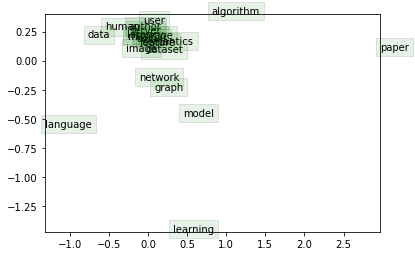

In [16]:
visualizeWords = [
"graph", "model","network","author","language","paper","server",
    "storage","latency","circuit","algorithm","semantics","learning",
    "image","music","user","human","data","dataset","feature"]


# visualizeWords = [
#     "cache", "memory","time","paper","language","model"
# ]


visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2])

for i in range(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i],
        bbox=dict(facecolor='green', alpha=0.1))

plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))

#plt.savefig('word_vectors.png')

In [11]:
def get_similarity(x1, x2):
    similarity = np.dot(wordVectors[tokens[x1]],
                   wordVectors[tokens[x2]]) / (np.linalg.norm(
    wordVectors[tokens[x1]]) * np.linalg.norm(
    wordVectors[tokens[x2]]))
    return similarity

In [12]:
get_similarity("cache","memory")

0.9890256105269071

In [13]:
get_similarity("cache","language")

0.8224346008446329

In [14]:
get_similarity("user","paper")

0.7342492311703378

In [15]:
get_similarity("time","paper")

0.5677164998674551